## My first CNN: Digit recognition with Keras 

I build a model to classify digits 0 through 9, using convolutional neural networks in python with keras.

This was a part of a kaggle competition. The model achieved 99.36% accuracy on Kaggle's test set, and trains in ~30 minutes on my CPU

## Load packages and data

In [22]:
import pandas as pd
import numpy as np
import keras as ks
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

## Summarise data

Check for null values in the dataset (corrupted images): none were found



In [23]:
# Check for null values
train.isna().sum().sum()
test.isna().sum().sum()

0

Check how many training examples are available for each digit. If any digit has too few training examples, then it may need to be addressed. Here, a large number of training examples were available for all digits, so there is no issue.

In [24]:
train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

## Preprocess data
Normalize values so that they range between 0-1, which can help the model fit more quickly, and possibly achieve a better fit.

Data also need to be reshaped: In the provided dataset, each image is represented as a single row from a matrix, but Conv2D expects images to be presented with a 3-D input shape

In [25]:
#%% Preprocess
y_train =  train['label'].copy()
X_train =  train.drop(['label'], axis = 1)

# Normalize pixel values which helps during model fitting
X_train = (X_train / 255)
test = (test / 255)

# Convert to numpy arrays which play well with keras
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
test = test.to_numpy()

# one-hot encode the response variable, the required imput for this NN in keras
y_train = to_categorical(y_train)


# Pixel values for the 28 * 28 image were flattened into a single row in the 
# provided data files. Reconstruct the 3D structure, which is needed for 
# keras's Conv2D(): 28 (rows) * 28 (columns) * 1 (channel i.e. grayscale)

X_train = X_train.reshape(-1,28,28,1)
test = test.reshape(-1,28,28,1)

#### Check that reshaping worked
After reshaping, plot some random images from the dataset to check that it worked as expected, and to get a feel for what the images look like. We will also see the one-hot encoded labels. The cell below can be re-run to get different examples

Text(0.5, 1.0, 'Character is labelled as: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]')

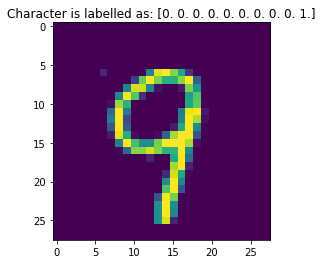

In [26]:
random_int = np.random.randint(0, len(X_train))
plt.imshow(X_train[random_int][:,:,0])
plt.title("Character is labelled as: " + str(y_train[random_int]))

### Split into training and validation sets
We will not create our own test set, because we can evaluate our final 
model on Kaggle's test set when we submit results


In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size = 0.2, random_state=100
    )

## Data Augmentation
We will use data augmentation to add distortions to the original training images in order to increase the effective sample size. We can do with with keras's ImageDataGenerator. It takes out original images and adds random distortions according to the parameters that we specify. A different distortion is applied to each image in the training set after each epoch.

When we fit the model, instead of providing our raw dataset, we provide the generated images.

We will add rotations, position shifts, zoom, and shear.


In [28]:
datagen = ks.preprocessing.image.ImageDataGenerator(
    rotation_range=0.1, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.1, zoom_range=0.1
    )
datagen.fit(X_train) # I'm not sure if 'fitting' is necessary for these datagen parameters, but it shouldn't hurt

To get an example of an image with random distortions, run the below block of code

Text(0.5, 1.0, 'Character is labelled as: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]')

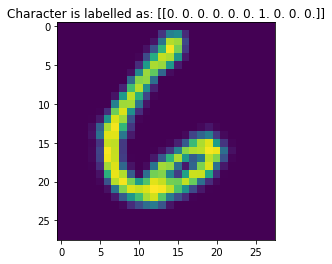

In [29]:
iterator = datagen.flow(X_train, y_train, batch_size = 1)
sample = iterator.next()
plt.imshow((sample[0][0]*255).astype('uint8'))
plt.title("Character is labelled as: " + str(sample[1]))

## Specify the structure of the CNN
We will build the neural network using keras's high-level API. 
We will use 4 pairs of Conv2D and pooling layers. 
We'll also randomly drop 25-50% of weights in each layer to reduce overfitting.
We flatten the results and pass through a final Dense layer before the output layer. The output layer should be specified as 'softmax', which means that output node values can be interpreted as probabilities, and will sum to 1 across all classes.


In [30]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu', 
                      padding = 'Same',input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10,activation='softmax'))

## Specify the optimizer & early stopping rule
I'll use the adam optimizer, which is meant to work well for many applications. categorical_crossentropy is the loss function required for multi-class classification.

We will set up an early stopping instance which will be used by the model during training. If there are signs of overfitting, it will terminate training and revert to the model with the lowest validation loss. If processing power is limited, patience could be reduced (e.g. to ~2-5) to terminate training earlier.






In [31]:
model.compile(
    optimizer = 'adam', loss = 'categorical_crossentropy', metrics=(['accuracy'])
)

early_stopping = EarlyStopping(
    monitor = 'val_loss', patience = 10, restore_best_weights = True
)

# Saving checkpoints of the model after each epoch during training can 
# also be helpful (e.g. if training is interrupted)
model_checkpoint = ModelCheckpoint(
    'Digit_CNN_best.hdf5', monitor = 'val_loss', save_best_only=True
)

## Fit the model
I'll use an unreasonably high number of epochs, given that I have an early stopping rule in place. My best model, according to validation loss, was found after ~30 epochs.


In [ ]:
#%% Fit the model

hist = model.fit(datagen.flow(X_train, y_train, batch_size = 32),
                                     epochs = 100, 
                                     validation_data = (X_val, y_val),
                 callbacks = [early_stopping, model_checkpoint])

#best_model = ks.models.load_model('Digit_CNN_best.hdf5') # re-load the best model from disk if desired


## Model diagnotics
We will plot the change in training loss and the validation loss during training, which can help detect overfitting.

In [ ]:
# Model diagnostics
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Val', 'Train'])

## Generate predictions and export results


In [ ]:
preds = model.predict(test)

# Convert from one-hot encoding back to a single variable
preds_transform = preds.argmax(axis=1)

# Create a dataframe in the format requried by kaggle, and export to a csv
indexes = np.arange(1,len(preds_transform)+1)
results = pd.DataFrame({"ImageId": indexes, "Label": preds_transform})
results.to_csv("CNN predictions.csv", index = False)




## Possible ways to try and improve the model further.
* Try different architectures (number of layers, number of filters per layer)
* Try using batch normalization 
* Try different optimisers, and tuning optimizer parameters (e.g. learning rate)